<a href="https://colab.research.google.com/github/tphlabs/timetable_validity/blob/main/Timetable2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate groups

v.0.1.2

Physics Dept 2023/2024:[Catalogue](https://ugportal.technion.ac.il/wp-content/uploads/2024/02/11-%D7%A4%D7%99%D7%96%D7%99%D7%A7%D7%94-%D7%AA%D7%A9%D7%A4%D7%B4%D7%93.pdf):

In [18]:
import requests
import json
import numpy as np
import itertools

# full catalogue of courses fetched from SAP
# semester 2024_201 (winter 24/25)
# source code: https://github.com/michael-maltsev/technion-sap-info-fetcher
url = 'https://raw.githubusercontent.com/tphlabs/timetable_validity/main/2024_201.json'
response = requests.get(url)
data = json.loads(response.text)
print(f'Loaded {len(data)} courses')

Loaded 1058 courses


In [17]:
# function to make hoursmap as 2d np array days x hours
# we read day and hours out of text description in timeslot
# suggested that all timeslots start and xx:30, between 08:30 and 19:30,
# which is not quite so for all published courses (sports may be exception)

WEEK = ['ראשון','שני','שלישי','רביעי','חמישי']
SLOTS = [f'{h:02d}:30' for  h in range(8, 18)] # 1 hour slots

def EMPTY_MAP():
  return np.zeros((len(WEEK), len(SLOTS)), dtype=int)

def parse_slot(slot):
  group_type = slot['סוג']
  group_number = slot['קבוצה']
  group_hour = slot['שעה']
  group_day = slot['יום']
  hours_map = EMPTY_MAP()
  hours_from, hours_to = group_hour.split(' - ')
  if hours_from not in SLOTS or hours_to not in SLOTS:
    # error message: irregular hours
    return 0
  hours_from_ind, hours_to_ind = SLOTS.index(hours_from), SLOTS.index(hours_to)
  days_ind = WEEK.index(group_day)
  hours_map[days_ind, hours_from_ind:hours_to_ind] = 1
  return hours_map

# Semester 1

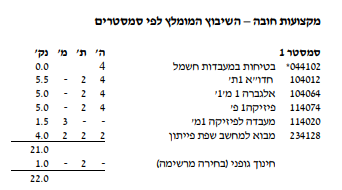

In [13]:
semester = ['01040012', '01040064', '01140074','02340128']

courses = [course for course in data if course['general']['מספר מקצוע'] in semester]

with open('physics-semester1.json', 'w', encoding='utf-8') as f:
    json.dump(courses, f, ensure_ascii=False, indent=2)

.... clean up and upload to github ....

In [5]:
url = 'https://raw.githubusercontent.com/tphlabs/timetable_validity/main/physics-semester1.json'
response = requests.get(url)
data = json.loads(response.text)
print(f'Loaded {len(data)} courses')

Loaded 4 courses


In [7]:
# make activities for basic courses
activity = {}

for course in data:
  course_id = course['general']['מספר מקצוע']

  activity[course_id] = {}
  slots = course['schedule']
  for slot in slots:
    group_id = str(slot['קבוצה'])

    activity[course_id][group_id] = \
      activity[course_id].get(group_id, EMPTY_MAP()) + parse_slot(slot)


In [10]:
laboratory = '114020'
activity[laboratory] = {}
for day in range(len(WEEK)):
  for hour in [0,1, 3,4, 6,7]:
    hourmap = EMPTY_MAP()
    hourmap[day,hour:hour+3] = 1
    groupname = f'{day+1}.{SLOTS[hour][:3]}'
    #print(f'{groupname}\n {hourmap}')
    activity[laboratory][groupname] = hourmap

In [12]:
# here is the cell  where all possible combination of groups for each activity are created
# and checked against feasibility by aggregating their hour maps
# feasible combination has only ones and zeroes in aggregated hours map
# 2 and more means activities overlapping

# list of iterators: for each course all groups
combins = [
            [f'{course}_{group}' for group in activity[course]]
            for course in activity.keys()
         ]


rating = {} # group rating counter

#print('Feasible combinations:')
for combination in itertools.product(*combins):
    # init hourmap with zeroes
    check = EMPTY_MAP()

    for group in combination:
      # init counter if met 1st time
      rating[group] = rating.get(group, 0)
      # extract course and group ids from element in combinations
      course_id, group_id = group.split('_')
      # aggregate hours for groups in combination
      check += activity[course_id][group_id]
    # check aggregated hourmap against overload criterion
    if np.sum(check > 1) > 0: #
      continue
    # print out combination that meets feasibility criteria
    #print(combination)
    #print(check)

    # aggregate rating counter
    for group in combination:
      rating[group] += 1

print('Group rating:')
for group in sorted(rating):
  course_id = group.split('_')[0]
  if course_id == laboratory:
    print(f'{group}: {rating[group]}')

Group rating:
114020_1.08:: 69
114020_1.09:: 69
114020_1.11:: 105
114020_1.12:: 81
114020_1.14:: 131
114020_1.15:: 131
114020_2.08:: 78
114020_2.09:: 78
114020_2.11:: 50
114020_2.12:: 19
114020_2.14:: 38
114020_2.15:: 38
114020_3.08:: 0
114020_3.09:: 0
114020_3.11:: 0
114020_3.12:: 84
114020_3.14:: 224
114020_3.15:: 224
114020_4.08:: 13
114020_4.09:: 13
114020_4.11:: 126
114020_4.12:: 176
114020_4.14:: 121
114020_4.15:: 121
114020_5.08:: 0
114020_5.09:: 0
114020_5.11:: 0
114020_5.12:: 115
114020_5.14:: 224
114020_5.15:: 224


# Semester 2

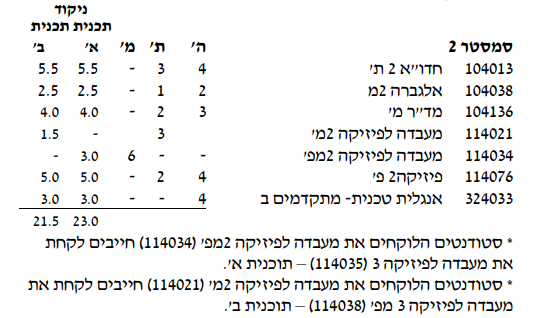

In [16]:
semester = ['01040013', '01040038', '01040136','01040076','03240033']

courses = [course for course in data if course['general']['מספר מקצוע'] in semester]

with open('physics-semester2.json', 'w', encoding='utf-8') as f:
    json.dump(courses, f, ensure_ascii=False, indent=2)

.... clean up and upload to github ...

In [38]:
url = 'https://raw.githubusercontent.com/tphlabs/timetable_validity/main/physics-semester2.json'
response = requests.get(url)
data = json.loads(response.text)

print(f'Loaded {len(data)} courses')

Loaded 4 courses


In [40]:
# make activities for basic courses
activity = {}

for course in data:
  course_id = course['general']['מספר מקצוע']

  activity[course_id] = {}
  slots = course['schedule']
  for slot in slots:
    group_id = str(slot['קבוצה'])

    activity[course_id][group_id] = \
      activity[course_id].get(group_id, EMPTY_MAP()) + parse_slot(slot)

laboratory = '114021'
activity[laboratory] = {}
for day in range(len(WEEK)):
  for hour in [0,1, 3,4, 6,7]:
    hourmap = EMPTY_MAP()
    hourmap[day,hour:hour+3] = 1
    groupname = f'{day+1}.{SLOTS[hour][:3]}'
    #print(f'{groupname}\n {hourmap}')
    activity[laboratory][groupname] = hourmap

In [41]:
# here is the cell  where all possible combination of groups for each activity are created
# and checked against feasibility by aggregating their hour maps
# feasible combination has only ones and zeroes in aggregated hours map
# 2 and more means activities overlapping

# list of iterators: for each course all groups
combins = [
            [f'{course}_{group}' for group in activity[course]]
            for course in activity.keys()
         ]


rating = {} # group rating counter

#print('Feasible combinations:')
for combination in itertools.product(*combins):
    # init hourmap with zeroes
    check = EMPTY_MAP()

    for group in combination:
      # init counter if met 1st time
      rating[group] = rating.get(group, 0)
      # extract course and group ids from element in combinations
      course_id, group_id = group.split('_')
      # aggregate hours for groups in combination
      check += activity[course_id][group_id]
    # check aggregated hourmap against overload criterion
    if np.sum(check > 1) > 0: #
      continue
    # print out combination that meets feasibility criteria
    #print(combination)
    #print(check)

    # aggregate rating counter
    for group in combination:
      rating[group] += 1

print('Group rating:')
for group in sorted(rating):
  course_id = group.split('_')[0]
  if course_id == laboratory:
    print(f'{group}: {rating[group]}')

Group rating:
114021_1.08:: 57
114021_1.09:: 38
114021_1.11:: 23
114021_1.12:: 47
114021_1.14:: 75
114021_1.15:: 75
114021_2.08:: 0
114021_2.09:: 0
114021_2.11:: 0
114021_2.12:: 33
114021_2.14:: 88
114021_2.15:: 88
114021_3.08:: 0
114021_3.09:: 0
114021_3.11:: 0
114021_3.12:: 20
114021_3.14:: 32
114021_3.15:: 67
114021_4.08:: 0
114021_4.09:: 0
114021_4.11:: 0
114021_4.12:: 33
114021_4.14:: 12
114021_4.15:: 32
114021_5.08:: 19
114021_5.09:: 42
114021_5.11:: 58
114021_5.12:: 83
114021_5.14:: 83
114021_5.15:: 83
